### Exploratory Data Analysis (EDA)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Generate Synthetic Time Series Data

np.random.seed(42)

dates = [datetime(2020, 1, 1) + timedelta(days=i) for i in range(200)]
trend = np.linspace(0, 10, 200)  # Small upward trend
noise = np.random.randn(200) * 2  # Random noise
values = 50 + trend + np.cumsum(noise)  # Simulated time series


# Create DataFrame

df = pd.DataFrame({'Date': dates, 'Value': values})
df.set_index('Date', inplace=True)

### Plot the Time Series

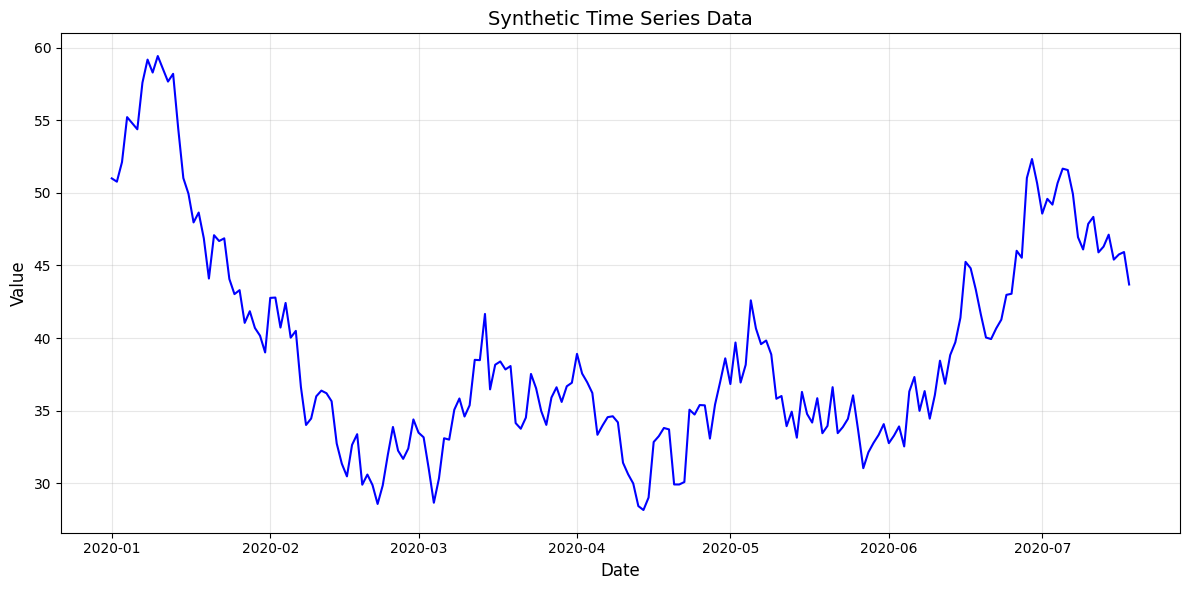

In [8]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'], 'b-')
plt.title('Synthetic Time Series Data', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Summary Statistics 

In [11]:
# Calculate summary statistics
summary_stats = df['Value'].describe()
print("Summary Statistics:")
print(summary_stats)

# Additional statistics
variance = df['Value'].var()
print(f"\nVariance: {variance:.4f}")

# Range
min_value = df['Value'].min()
max_value = df['Value'].max()
value_range = max_value - min_value
print(f"Range: {value_range:.4f} (Min: {min_value:.4f}, Max: {max_value:.4f})")

Summary Statistics:
count    200.000000
mean      39.166781
std        7.302613
min       28.172240
25%       33.915964
50%       36.658943
75%       43.315119
max       59.413484
Name: Value, dtype: float64

Variance: 53.3282
Range: 31.2412 (Min: 28.1722, Max: 59.4135)


### Check for missing values and handle them if necessary.

In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in the dataset:")
print(missing_values)

Missing values in the dataset:
Value    0
dtype: int64


### Calculate rolling statistics to see how they change over time 20 Day Window

These statistics and visualizations will help to understand the central tendency, dispersion, and temporal patterns in the synthetic time series data. The rolling statistics are particularly useful for time series analysis as they show how data characteristics evolve over time.

In [13]:
rolling_window = 20  # 20-day window
rolling_mean = df['Value'].rolling(window=rolling_window).mean()
rolling_std = df['Value'].rolling(window=rolling_window).std()

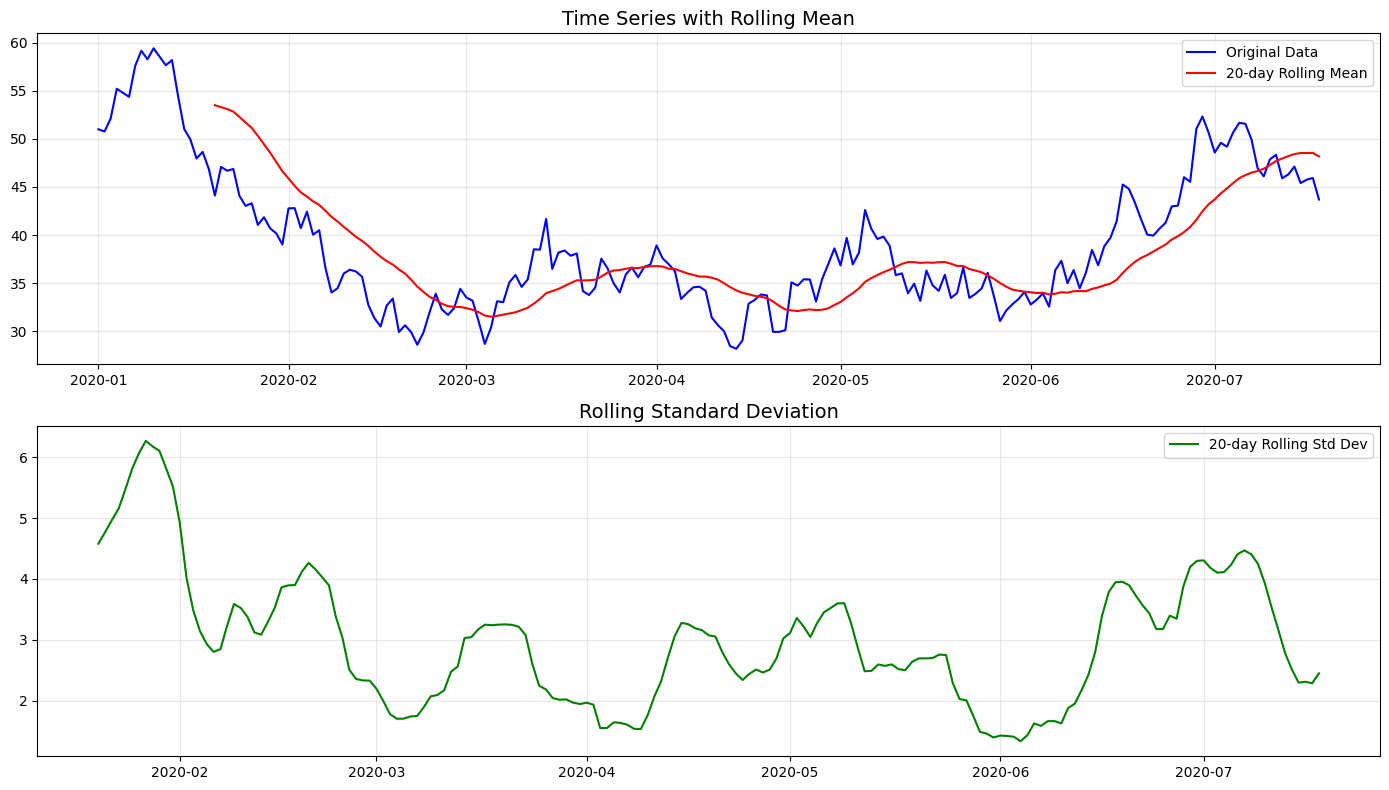

In [14]:
# Plot the time series with rolling statistics
plt.figure(figsize=(14, 8))

# Original data
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Value'], 'b-', label='Original Data')
plt.plot(rolling_mean.index, rolling_mean, 'r-', label=f'{rolling_window}-day Rolling Mean')
plt.title('Time Series with Rolling Mean', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Standard deviation
plt.subplot(2, 1, 2)
plt.plot(rolling_std.index, rolling_std, 'g-', label=f'{rolling_window}-day Rolling Std Dev')
plt.title('Rolling Standard Deviation', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()